## Predictive Classification Modeling for Water Quality  
- Potabile (Safe) vs Not Potabile (Unsafe).

I selected this topic and dataset as a final (Portfolio) project for
Codecademy's learning path: *Machine Learning/AI Engineer*  

### In so doing I will follow the ML (Machine Learning) workflow taught therein: 
1. ETL (Extract, Transform and Load) data
2. Data Cleaning
3. Train-Test-Validation Split
4. EDA (Exploratory Data Analysis)
5. Feature Engineering (normalization, removing autocorrelations, discretization, etc.)
6. Model Selection and Implementation
7. Model Evaluation
8. Hyperparameter Tuning
9. Model Validation
10. Build ML pipeline!

Please refer to my [github repository](https://github.com/jf-grpo/Water-Quality-Classification-Modeling) for a complete look at all Jupyter Notebooks I developed during this project.  
Examples Include:  
- Feature Engineering (Correllation and Variance)
- EDA
- Model Selection, Evaluation, and Implementation
- Learning notes and insights for each step.

### Steps

- Import required libraries/packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, make_scorer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline

- Load Dataset
- Separate features, target (X, y)
- Split into Training & testing data

In [2]:
df = pd.read_csv('water_potability_AdityaKadiwal.csv')
# fillWithMean = df.apply(lambda col: col.fillna(col.mean()), axis=0)

X = df.drop(columns=['Potability'])
y = df['Potability']

X_train, X_test, y_train, y_test = train_test_split(
    X,  
    y, 
    test_size=0.25,
    random_state=0)

##### This dataset is only numerical so some of the following is not necessary.  
##### But, I've added it to prepare a pipeline should you want to run new datasets through.  
- define variables that separate Numerical & Categorical data types.
- define variables to store impuned data.
- here we use "strategy='mean'" to fill NaN (nulls) with the column average & then Standardize numerical data.
- for categorical data we choose "strategy='most_frequent' to fill NaN (nulls) with the most frequently occuring value.
  then use [One Hot Encoding](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html).
- Finally, we use [ColumnTransformer](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html) to handle and store all of 
  this in the variable 'preprocess'.

##### Note: 
I researched whether or not 'Standardizing the Target' was necessary. I found many opinions on this but no consensus.  
Most of those in favor cited the effects of very large target ranges. Here we only have 0 and 1. So, I decided NOT to apply  
standardization to the target. I did some during testing of each model and it did not have any significant effect on the output.

In [3]:
# Assuming X and y are your features and target
num_cols = X.select_dtypes(include=np.number).columns
cat_cols = X.select_dtypes(include=['object']).columns

# Define preprocessing steps
num_vals = Pipeline([("imputer", SimpleImputer(strategy='mean')), ("scale", StandardScaler())])
cat_vals = Pipeline([("imputer", SimpleImputer(strategy='most_frequent')), ("ohe", OneHotEncoder(sparse_output=False, drop='first'))])

# Create column transformer that will preprocess the numerical and categorical features separately
preprocess = ColumnTransformer(
    transformers=[
        ("cat_preprocess", cat_vals, cat_cols),
        ("num_preprocess", num_vals, num_cols)
    ]
)

- Define variables for each model selected and use [Pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html#pipeline) to 
  add the above preprocess to each.

In [4]:
# Define pipelines for each classifier
svc_pipeline = Pipeline([
    ('preprocess', preprocess),
    ('svc', SVC())
])

knn_pipeline = Pipeline([
    ('preprocess', preprocess),
    ('knn', KNeighborsClassifier())
])

tree_pipeline = Pipeline([
    ('preprocess', preprocess),
    ('tree', DecisionTreeClassifier())
])
random_forest = Pipeline([
    ('preprocess', preprocess),
    ('randomforest', RandomForestClassifier())
])

- Select hyperparemeters to tune for each model and store in the 'param_grid' variable for use in [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#gridsearchcv).

In [5]:
# Parameter grid for GridSearchCV
param_grid = [
    {
        'svc__C': [0.1, 1, 10]
    },
    {
        'knn__n_neighbors': [3, 5, 7]
    },
    {
        'tree__max_depth': [2, 3, 4, 6, 8]
    },
    {
        'randomforest__max_depth': [2, 3, 4, 6, 8]
    }
    
]

##### In this code:

- Custom Scorers: The make_scorer function is used to create custom scoring functions for accuracy, precision, recall, and F1 score.
- Scoring Parameter: These custom scorers are passed to the scoring parameter of GridSearchCV in a dictionary.
- Refit Parameter: The refit parameter is set to 'accuracy' to refit the model based on accuracy.
- Cross-validation Results: The cv_results_ attribute of GridSearchCV is used to extract the mean scores for each metric.
- This approach allows you to evaluate each model fed to GridSearchCV based on multiple metrics.

- Define 'scoring' variable with desired scores for the selected models. Use [make_scorer](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html#make-scorer) method.

In [6]:
# Define custom scorers
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, average='weighted', zero_division=0),
    'recall': make_scorer(recall_score, average='weighted', zero_division=0),
    'f1': make_scorer(f1_score, average='weighted', zero_division=0)
}

- Store pipeline variables in a list. *'for loop'* prep.
- Store names for Models in a list. *'for loop'* prep.

In [7]:
# List of pipelines & list for Model names
pipelines = [svc_pipeline, knn_pipeline, tree_pipeline, random_forest]
pipelines_names = ['SVC','KNeighborsClassifier','DecisionTreeClassifier','RandomForestClassifier']

- Run a for loop to process each model storing the results in a list.
- We'll leverage the 'results_list' variable to place results in a DataFrame & Visualizations.

In [8]:
# List to store results
results_list = []

# Perform GridSearchCV for each pipeline
for pipeline, params, name in zip(pipelines, param_grid, pipelines_names):
    grid_search = GridSearchCV(pipeline, params, cv=5, scoring=scoring, refit='accuracy', return_train_score=True)
    grid_search.fit(X_train, y_train)
 
    # Extract cross-validation results for the best parameters
    # Extract the index for best parameters
    best_index = grid_search.best_index_
    results = grid_search.cv_results_
    
    # Append the results to the list
    results_list.append({
        'Model': name,
        'Best Parameters': grid_search.best_params_,
        'Best Accuracy': results['mean_test_accuracy'][best_index],
        'Best Precision': results['mean_test_precision'][best_index],
        'Best Recall': results['mean_test_recall'][best_index],
        'Best F1': results['mean_test_f1'][best_index]
    })

# Convert the results list to a pandas DataFrame
results_df = pd.DataFrame(results_list)

#results_df
# Set the 'Model' column as the index
results_df.set_index('Model', inplace=True)

results_df

,Best Parameters,Best Accuracy,Best Precision,Best Recall,Best F1
Model,,,,,
SVC,{'svc__C': 1},0.674803,0.686933,0.674803,0.630711
KNeighborsClassifier,{'knn__n_neighbors': 7},0.632468,0.617112,0.632468,0.611435
DecisionTreeClassifier,{'tree__max_depth': 8},0.641423,0.630559,0.641423,0.593447
RandomForestClassifier,{'randomforest__max_depth': 8},0.649972,0.659709,0.649972,0.587088


- Use matplotlib to plot 'results_df' as a horizontal bar graph

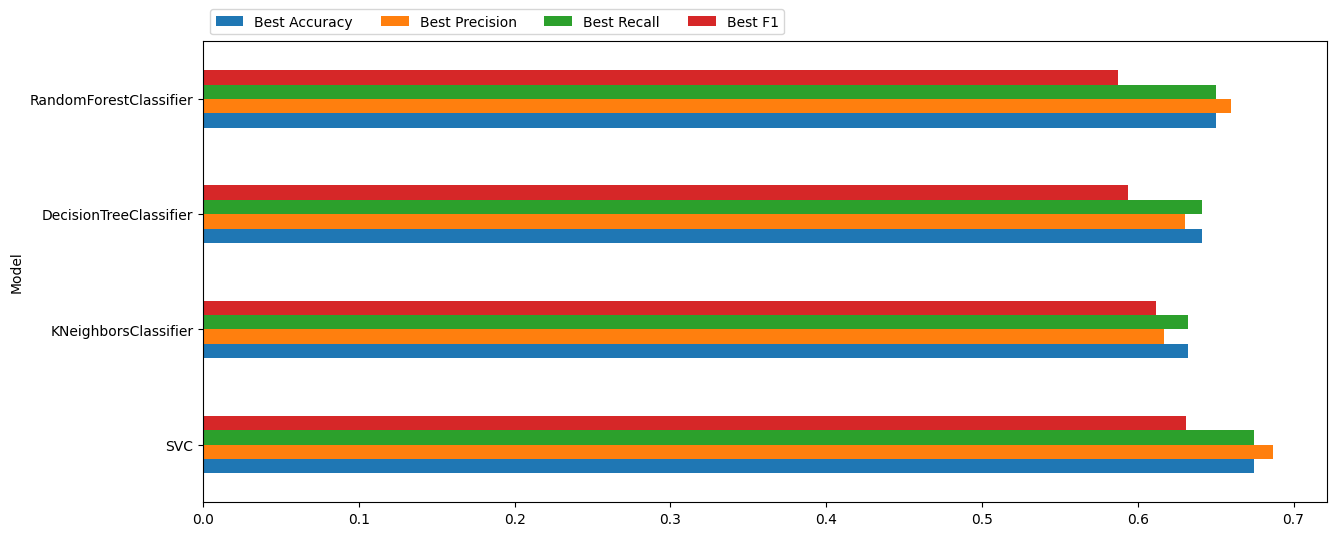

In [9]:
# Plotting the DataFrame as a horizontal bar graph with an increased figure size
fig, ax = plt.subplots(figsize=(14, 6))
results_df.plot.barh(ax=ax)

# Customize the legend
ax.legend(
    ncol=len(results_df.columns), 
    bbox_to_anchor=(0, 1), 
    loc='lower left', 
    prop={'size': 10}
)

# Apply tight layout with adjusted parameters
plt.tight_layout(pad=3.0, w_pad=1.0, h_pad=1.0)
plt.show()

### Resources, Kudos, and Credits 
#### Big Thank you to [Aditya Kadiwal](https://www.kaggle.com/adityakadiwal) for providing this great [dataset](https://www.kaggle.com/datasets/adityakadiwal/water-potability)!!!  
##### This is not an exhaustive list but the *highlights* of articles which assisted me in completing this project.
- [Choosing the right estimator](https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html) - Thanks to all the great contributers of scikit-learn!
- [Fatih Karabiber - Binary Classification](https://www.learndatasci.com/glossary/binary-classification/) - Great Article. Clear and concise.
- Standardize the Traget (DO or DO NOT).   
[Binary classification with regression analysis](https://stats.stackexchange.com/questions/111467/is-it-necessary-to-scale-the-target-value-in-addition-to-scaling-features-for-re) - Although this thread is about regression and not classification, I found the variety of opinions interesting. After reading them I decided NOT to standardize the target.  
It does not seem necessary given we are only dealing with 0 and 1.
- [Enjoy Machine Learning - ML:101: Feature Selection with SelectKBest](https://enjoymachinelearning.com/blog/feature-selection-selectkbest-sklearn/)
- [Pierian Training](https://pieriantraining.com/machine-learning-in-python-support-vector-machine-classification/) - Article & sample code for SVC. Well written.
- [Data TechNotes](https://www.datatechnotes.com/2020/06/classification-example-with-svc-in-python.html) - Another really great article & code sample for SVC.
- [Confusion Matrix: How To Use It & Interpret Results [Examples]](https://www.v7labs.com/blog/confusion-matrix-guide) - Nice thorough article on the Confusion Matrix.

### Conclusions, thoughts, findings  
I learned vastly more about each model while conducting this project.  In particular about their parameters and how to access them.  
The course work in Codecademy provided a solid baseline but you can never fully understand the concepts until applying them on a self-directed project.  
Conducting each model individually was far easier than putting them all into a pipeline. When building the pipeline, the most difficult piece is pulling out the parameters for each model. There is so much abstraction involved in the pipeline it makes it very difficult to understand how to access results.  
While getting started I found the biggest help (guide) from scikit-learn's 'Choosing the right estimator' cheetsheat. Otherwise I would have gone on indefinitley testing various models.  
In the end there was not much variation in the predictive abilities. SVC was slightly better than the other models. But, I think the dataset is just to small to make more accurate predictions.  
If I were to continue with this particular dataset, I would try the pipeline on a smaller set of features. I'm not certain it will make any better predictions. If you examine my 'FeatureEngineering' notebook, you'll find that each FE approach favored different metrics. I ended up just using them all.
One could shorten this code by using a 'Search Space' concept. But I had many errors trying to leverage that approach. I ended up just using the options of the GridSearchCV.  

###  Thanks again to all the aforementioned resource contributors. The Data Community is truly AWESOME!